In [79]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
# read data 
names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('data/ml-100k/u.data', sep='\t', names=names)
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
print(f'{n_users} users and {n_items} items')

943 users and 1682 items


## construct user-item matrix

In [8]:
# map user/item ID’s to user/item indices by offset them by 1.
ratings = np.zeros((n_users, n_items))
for row in df.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3]
print(ratings)

[[5. 3. 4. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [5. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 5. 0. ... 0. 0. 0.]]


In [12]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
print(f'Sparsity: {sparsity*100:4.2f}%')

Sparsity: 6.30%


In this dataset, every user has rated at least 20 movies which results in a reasonable sparsity of 6.3%. This means that 6.3% of the user-item ratings have a value. Note that, although we filled in missing ratings as 0, we should not assume these values to truly be zero. More appropriately, they are just empty entries. We will split our data into training and test sets by removing 10 ratings per user from the training set and placing them in the test set.

In [15]:
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=10, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

In [16]:
train, test = train_test_split(ratings)

## Collaborative filtering

We will focus on collaborative filtering models today which can be generally split into two classes: user- and item-based collaborative filtering. In either scenario, one builds a similarity matrix. For user-based collaborative filtering, the user-similarity matrix will consist of some distance metric that measures the similarity between any two pairs of users. Likewise, the item-similarity matrix will measure the similarity between any two pairs of items.

A common distance metric is [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity). The metric can be thought of geometrically if one treats a given user’s (item’s) row (column) of the ratings matrix as a vector. For user-based collaborative filtering, two users’ similarity is measured as the cosine of the angle between the two users’ vectors.

In [39]:
# cosine similarity calcuation
def cos_sim(ratings, kind='user', epsilon=1e-9):
    # epsilon is for handling dived-by-zero errors
    if kind == 'user':
        sim = ratings.dot(ratings.T) + epsilon
    elif kind == 'item':
        sim = ratings.T.dot(ratings) + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

In [18]:
%timeit cos_sim(train, kind='user')

26.6 ms ± 1.05 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
user_similarity = cos_sim(train, kind='user')
item_similarity = cos_sim(train, kind='item')
print(item_similarity[:4, :4])

[[1.         0.40025545 0.31372157 0.45905596]
 [0.40025545 1.         0.27284711 0.49435614]
 [0.31372157 0.27284711 1.         0.31095409]
 [0.45905596 0.49435614 0.31095409 1.        ]]


In [21]:
# predict ratings
def cs_predict(ratings, similarity, kind='user'):
    if kind == 'user':
        return similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif kind == 'item':
        return ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])

In [22]:
%timeit cs_predict(train, user_similarity, kind='user')

32.5 ms ± 2.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [23]:
# evaluate our predictions
from sklearn.metrics import mean_squared_error

def mse(pred, actual):
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [25]:
item_prediction = cs_predict(train, item_similarity, kind='item')
user_prediction = cs_predict(train, user_similarity, kind='user')

print(f'User-based CF MSE: {mse(item_prediction, test)}')
print(f'Item-based CF MSE: {mse(user_prediction, test)}')

User-based CF MSE: 11.553319900183364
Item-based CF MSE: 8.459810528533673


## Top-k Collaborative Filtering
We can attempt to improve our prediction MSE by only considering the top kk users who are most similar to the input user (or, similarly, the top k items)

In [28]:
def predict_topk(ratings, similarity, kind='user', k=40):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        for i in range(ratings.shape[0]):
            top_k_users = [np.argsort(similarity[:,i])[:-k-1:-1]]
            for j in range(ratings.shape[1]):
                pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users]) 
                pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
    if kind == 'item':
        for j in range(ratings.shape[1]):
            top_k_items = [np.argsort(similarity[:,j])[:-k-1:-1]]
            for i in range(ratings.shape[0]):
                pred[i, j] = similarity[j, :][top_k_items].dot(ratings[i, :][top_k_items].T) 
                pred[i, j] /= np.sum(np.abs(similarity[j, :][top_k_items]))        
    
    return pred

In [29]:
# evaluate
item_prediction = predict_topk(train, item_similarity, kind='item', k=40)
user_prediction = predict_topk(train, user_similarity, kind='user', k=40)

print(f'User-based CF MSE: {mse(item_prediction, test)}')
print(f'Item-based CF MSE: {mse(user_prediction, test)}')

C:\Users\michael\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]
C:\Users\michael\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
C:\Users\michael\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this 

User-based CF MSE: 7.727984483468394
Item-based CF MSE: 6.4988221215930535


In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_topk_performance(train, test, k_arr=[5, 15, 30, 50, 100, 200]):

    user_train_mse = []
    user_test_mse = []
    item_test_mse = []
    item_train_mse = []
    user_similarity = cos_sim(train, kind='user')
    item_similarity = cos_sim(train, kind='item')
    
    for k in k_arr:
        user_pred = predict_topk(train, user_similarity, kind='user', k=k)
        item_pred = predict_topk(train, item_similarity, kind='item', k=k)

        user_train_mse.append(mse(user_pred, train))
        user_test_mse.append(mse(user_pred, test))

        item_train_mse.append(mse(item_pred, train))
        item_test_mse.append(mse(item_pred, test))  

    
    sns.set()

    pal = sns.color_palette("Set2", 2)

    plt.figure(figsize=(8, 8))
    plt.plot(k_arr, user_train_mse, c=pal[0], label='User-based train', alpha=0.5, linewidth=5)
    plt.plot(k_arr, user_test_mse, c=pal[0], label='User-based test', linewidth=5)
    plt.plot(k_arr, item_train_mse, c=pal[1], label='Item-based train', alpha=0.5, linewidth=5)
    plt.plot(k_arr, item_test_mse, c=pal[1], label='Item-based test', linewidth=5)
    plt.legend(loc='best', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('k', fontsize=30)
    plt.ylabel('MSE', fontsize=30)
    plt.show()

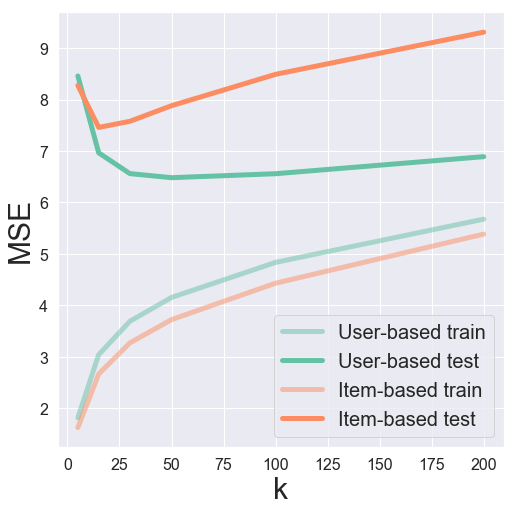

In [80]:
plot_topk_performance(train, test)